In [1]:
from sklearn.naive_bayes import GaussianNB
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

In [2]:
digits = load_digits()
X, y = digits.data, digits.target

In [3]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.3, random_state=420)

In [4]:
gnb = GaussianNB().fit(Xtrain, Ytrain)

In [5]:
acc_score = gnb.score(Xtest, Ytest)
acc_score

0.8592592592592593

In [6]:
# 预测结果
Y_pred = gnb.predict(Xtest)

In [39]:
# 预测的概率结果
prob = gnb.predict_proba(Xtest) 

In [8]:
Xtrain.shape

(1257, 64)

In [9]:
prob.shape

(540, 10)

In [10]:
prob[1, :].sum()

1.000000000000003

In [11]:
from sklearn.metrics import confusion_matrix as CM

In [12]:
CM(Ytest, Y_pred)

array([[47,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0, 46,  2,  0,  0,  0,  0,  3,  6,  2],
       [ 0,  2, 35,  0,  0,  0,  1,  0, 16,  0],
       [ 0,  0,  1, 40,  0,  1,  0,  3,  4,  0],
       [ 0,  0,  1,  0, 39,  0,  1,  4,  0,  0],
       [ 0,  0,  0,  2,  0, 58,  1,  1,  1,  0],
       [ 0,  0,  1,  0,  0,  1, 49,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 54,  0,  0],
       [ 0,  3,  0,  1,  0,  0,  0,  2, 55,  0],
       [ 1,  1,  0,  1,  2,  0,  0,  3,  7, 41]])

In [13]:
prob.sum(axis=1).shape

(540,)

In [14]:
# 探索高斯朴素贝叶斯擅长的数据集

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from time import time
import datetime

In [15]:
def plot_learning_curve(estimator, title, X, y
                        ,ax # 子图
                        ,ylim=None
                        ,cv=None
                        ,n_jobs=None
                       ):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs)
    
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training example")
    ax.set_ylabel("Score")
    ax.plot(train_sizes, np.mean(train_scores, axis=1), "o-", color="r", label="Training score")
    ax.plot(train_sizes, np.mean(test_scores, axis=1), "o-", color="g", label="Test score")
    ax.legend(loc="best")
    return ax

In [16]:
digits = load_digits()

In [17]:
X, y = digits.data, digits.target

In [18]:
X.shape

(1797, 64)

In [19]:
title = ["Naive Bayes", "Decision Tree", "SVM RBF", "Random Forest", "Logistic"]
model = [GaussianNB(), DTC(), SVC(gamma=0.001), RFC(n_estimators=50), LR(C=1, solver="lbfgs")]
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

Naive Bayes:00:03:814105
Decision Tree:00:00:962390
SVM RBF:00:06:133848
Random Forest:00:05:950736
Logistic:00:05:308631


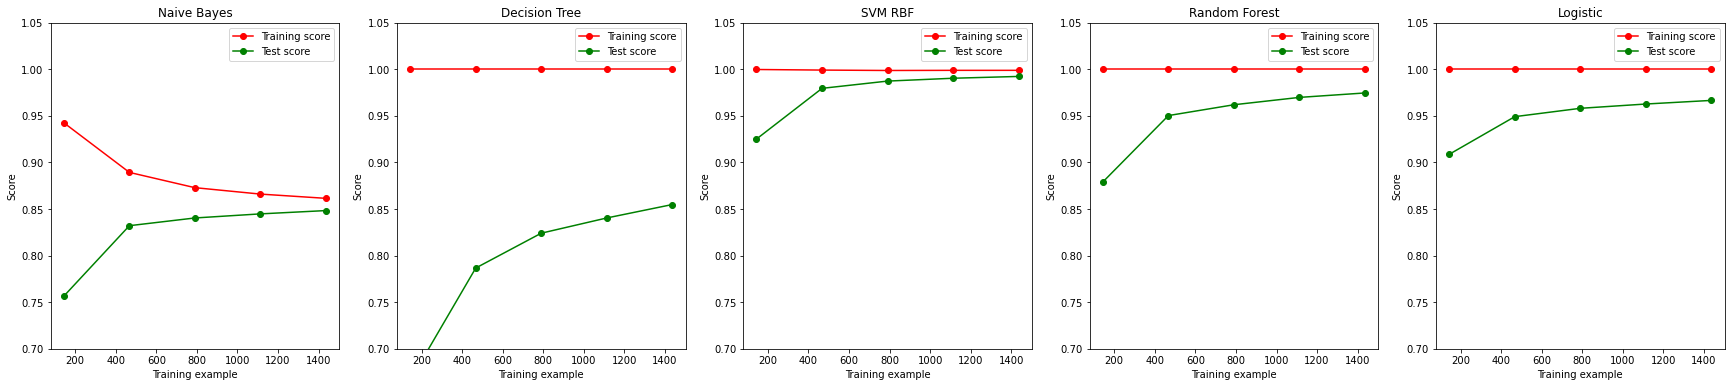

In [23]:
fig, axes = plt.subplots(1, 5, figsize=(30, 6))

for ind, title_, estimator in zip(range(len(title)), title, model):
    times = time()
    plot_learning_curve(estimator, title_, X, y,
                       ax=axes[ind], ylim=[0.7, 1.05], n_jobs=4, cv=cv)
    print("{}:{}".format(title_, datetime.datetime.fromtimestamp(time() - times).strftime("%M:%S:%f")))
    
plt.show()

In [24]:
# 概率类模型评估指标

In [25]:
# 布里尔分数

from sklearn.metrics import brier_score_loss

In [35]:
print(prob.shape)

(540, 10)


In [61]:
def get_brier_score(y_true, y_prob, pos_label):
    y_prob_ = y_prob.copy()[:, pos_label]
    y_true_ = y_true.copy()
    for i in range(len(y_true_)):
        if y_true_[i] == pos_label:
            y_true_[i] = 1
        else:
            y_true_[i] = 0
            
    score = brier_score_loss(y_true=y_true_, y_prob=y_prob_)
    return score 

In [62]:
get_brier_score(Ytest, prob, 1)

0.032619662406118764

In [63]:
for i in range(len(np.unique(Ytest))):
    score = get_brier_score(Ytest, prob, i)
    print(i, score)

0 0.003680512744365077
1 0.032619662406118764
2 0.04073796355303327
3 0.024227451061575995
4 0.013717124391784064
5 0.012770720966518715
6 0.008906952589951798
7 0.028006698663252037
8 0.0680707157691044
9 0.031524759298859326


In [64]:
logi = LR(C=1, solver="lbfgs", max_iter=3000, multi_class="auto").fit(Xtrain, Ytrain)
svc = SVC(kernel="linear", gamma=1).fit(Xtrain, Ytrain)

# 标签 1 的布里尔分数为 0.11，比朴素贝叶斯接近 0
get_brier_score(Ytest, logi.predict_proba(Xtest), 1)

0.011425333144596171

In [65]:
# 将置信度 (距离) 归一化到 0 ~ 1
svc_prob = (svc.decision_function(Xtest) - svc.decision_function(Xtest).min()) / (svc.decision_function(Xtest).max() - svc.decision_function(Xtest).min())

# 标签 1 上，SVC 的布里尔分数差很多
get_brier_score(Ytest, svc_prob, 1)

0.24286480465579566

In [66]:
import pandas as pd

No handles with labels found to put in legend.


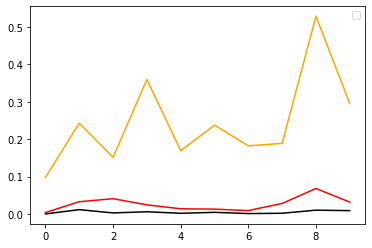

In [69]:
name = ["Bayes", "Logistic", "SVC"]
color = ["red", "black", "orange"]

df = pd.DataFrame(index=range(10), columns=name)
for i in range(10):
    df.loc[i, name[0]] = get_brier_score(Ytest, prob, i)
    df.loc[i, name[1]] = get_brier_score(Ytest, logi.predict_proba(Xtest), i)
    df.loc[i, name[2]] = get_brier_score(Ytest, svc_prob, i)

for i in range(df.shape[1]):
    plt.plot(range(10), df.iloc[:, i], c=color[i])
plt.legend()
plt.show()

In [70]:
# 对数似然

from sklearn.metrics import log_loss

In [71]:
log_loss(Ytest, prob)

2.4725653911460683

In [73]:
log_loss(Ytest, logi.predict_proba(Xtest))

0.12753003440467742

In [74]:
log_loss(Ytest, svc_prob)

1.6074987533411256

In [75]:
from sklearn.datasets import make_classification as mc

In [76]:
X, y = mc(n_samples=100000
          ,n_features=20 # 20 个特征
          ,n_classes=2
          ,n_informative=2 # 两个代表较多信息的特征
          ,n_redundant=10 # 10 个冗余特征
          ,random_state=42
         )

In [81]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.99, random_state=42)

In [82]:
Xtrain.shape

(1000, 20)

In [83]:
np.unique(Ytrain)

array([0, 1])

In [84]:
gnb = GaussianNB()
gnb.fit(Xtrain, Ytrain)
y_pred = gnb.predict(Xtest)
prob_pos = gnb.predict_proba(Xtest)[:, 1]

In [86]:
# 用字典创建
df = pd.DataFrame({"ytrue": Ytest[:500], "probability": prob_pos[:500]})

In [87]:
df

,ytrue,probability
0,1,9.999997e-01
1,0,9.999964e-01
2,1,1.000000e+00
3,1,9.886612e-01
4,0,8.441773e-18
...,...,...
495,0,9.224911e-04
496,1,9.931903e-01
497,0,5.670253e-06
498,0,8.248345e-08


In [88]:
df = df.sort_values(by="probability")

In [89]:
df

,ytrue,probability
31,0,1.824809e-21
144,0,6.610435e-21
175,0,4.171566e-19
4,0,8.441773e-18
284,0,1.463199e-17
...,...,...
207,1,1.000000e+00
102,1,1.000000e+00
107,1,1.000000e+00
47,1,1.000000e+00


In [91]:
df.index = range(df.shape[0]) # shape[0] 行数

In [92]:
df

,ytrue,probability
0,0,1.824809e-21
1,0,6.610435e-21
2,0,4.171566e-19
3,0,8.441773e-18
4,0,1.463199e-17
...,...,...
495,1,1.000000e+00
496,1,1.000000e+00
497,1,1.000000e+00
498,1,1.000000e+00


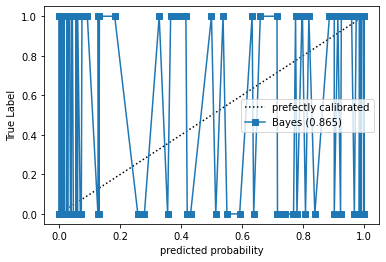

In [99]:
clf_score = prob_pos

fig = plt.figure()
ax1 = plt.subplot()
ax1.plot([0, 1], [0, 1], "k:", label="prefectly calibrated")
ax1.plot(df["probability"], df["ytrue"], "s-", label="{} ({:1.3f})".format("Bayes", gnb.score(Xtest, Ytest)))
ax1.set_ylabel("True Label")
ax1.set_xlabel("predicted probability")
ax1.set_ylim([-0.05, 1.05])
ax1.legend()
plt.show()

# 所有点的 y 都是 0, 1，这不对，应该是 [0, 1] 之间

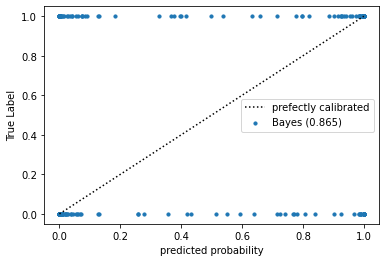

In [101]:
clf_score = prob_pos

fig = plt.figure()
ax1 = plt.subplot()
ax1.plot([0, 1], [0, 1], "k:", label="prefectly calibrated")
ax1.scatter(df["probability"], df["ytrue"], s=10, label="{} ({:1.3f})".format("Bayes", gnb.score(Xtest, Ytest)))
ax1.set_ylabel("True Label")
ax1.set_xlabel("predicted probability")
ax1.set_ylim([-0.05, 1.05])
ax1.legend()
plt.show()

In [102]:
from sklearn.calibration import calibration_curve

In [113]:
trueproba, predproba = calibration_curve(Ytest, prob_pos, n_bins=10)

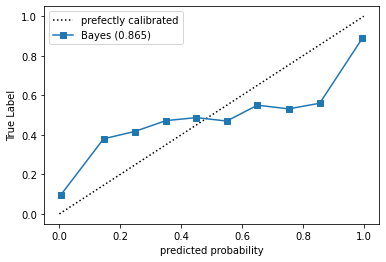

In [114]:
fig = plt.figure()
ax1 = plt.subplot()
ax1.plot([0, 1], [0, 1], "k:", label="prefectly calibrated")
ax1.plot(predproba, trueproba, "s-", label="{} ({:1.3f})".format("Bayes", gnb.score(Xtest, Ytest)))
ax1.set_ylabel("True Label")
ax1.set_xlabel("predicted probability")
ax1.set_ylim([-0.05, 1.05])
ax1.legend()
plt.show()

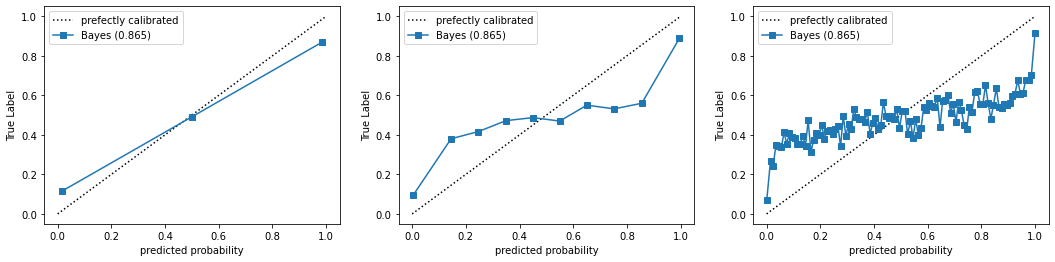

In [115]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
for ind, i in enumerate([3, 10, 100]):
    ax = axes[ind]
    trueproba, predproba = calibration_curve(Ytest, prob_pos, n_bins=i)
    ax.plot([0, 1], [0, 1], "k:", label="prefectly calibrated")
    ax.plot(predproba, trueproba, "s-", label="{} ({:1.3f})".format("Bayes", gnb.score(Xtest, Ytest)))
    ax.set_ylabel("True Label")
    ax.set_xlabel("predicted probability")
    ax.set_ylim([-0.05, 1.05])
    ax.legend()


In [116]:
# 更多模型的校准曲线

name = ["GaussionBayes", "Logistic", "SVC"]
gnb = GaussianNB()
logi = LR(C=1, solver="lbfgs", max_iter=3000, multi_class="auto")
svc = SVC(kernel="linear", gamma=1)

GaussianNB() GaussionBayes
LogisticRegression(C=1, max_iter=3000) Logistic
SVC(gamma=1, kernel='linear') SVC


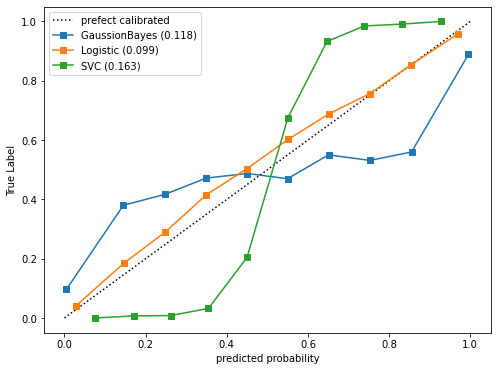

In [126]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot([0, 1], [0, 1], "k:", label="prefect calibrated")

for clf, name_ in zip([gnb, logi, svc], name):
    print(clf, name_)
    clf.fit(Xtrain, Ytrain)
    y_pred = clf.predict(Xtest)
    # 查看类 clf 是否有 precit_proba 接口
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(Xtest)[:, 1]
    else:
        prob_pos = clf.decision_function(Xtest)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    clf_score = brier_score_loss(Ytest, prob_pos)
    trueproba, predproba = calibration_curve(Ytest, prob_pos, n_bins=10)
    ax1.plot(predproba, trueproba, "s-", label="{} ({:1.3f})".format(name_, clf_score))
    
ax1.set_ylabel("True Label")
ax1.set_xlabel("predicted probability")
ax1.set_ylim([-0.05, 1.05])
ax1.legend()
plt.show()

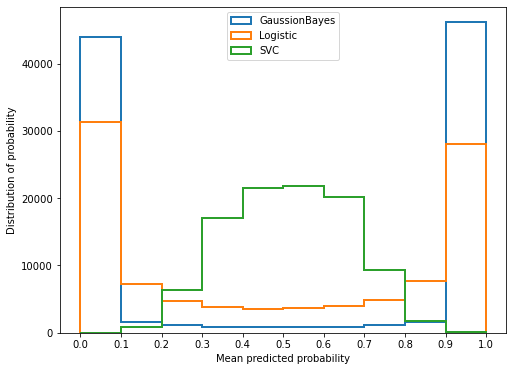

In [129]:
# 预测概率的直方图

fig, ax2 = plt.subplots(figsize=(8, 6))

for clf, name_ in zip([gnb, logi, svc], name):
    clf.fit(Xtrain, Ytrain)
    y_pred = clf.predict(Xtest)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(Xtest)[:, 1]
    else:
        prob_pos = clf.decision_function(Xtest)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    ax2.hist(prob_pos
             ,bins=10
             ,label=name_
             ,histtype="step"
             ,lw=2
            )
    
ax2.set_ylabel("Distribution of probability")
ax2.set_xlabel("Mean predicted probability")
ax2.set_xlim([-0.05, 1.05])
ax2.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax2.legend(loc=9)
plt.show()

In [132]:
def plot_calib(models, name, Xtrain, Xtest, Ytrain, Ytest, n_bins=10):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    ax1.plot([0, 1], [0, 1], "k:", label="perfectly calibrated")
    
    for clf, name_ in zip(models, name):
        print(clf, name_)
        clf.fit(Xtrain, Ytrain)
        y_pred = clf.predict(Xtest)
        # 查看类 clf 是否有 precit_proba 接口
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(Xtest)[:, 1]
        else:
            prob_pos = clf.decision_function(Xtest)
            prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        clf_score = brier_score_loss(Ytest, prob_pos)
        trueproba, predproba = calibration_curve(Ytest, prob_pos, n_bins=10)
        ax1.plot(predproba, trueproba, "s-", label="{} ({:1.3f})".format(name_, clf_score))
        ax2.hist(prob_pos
                 ,bins=10
                 ,label=name_
                 ,histtype="step"
                 ,lw=2
                )
        
    ax2.set_ylabel("Distribution of probability")
    ax2.set_xlabel("Mean predicted probability")
    ax2.set_xlim([-0.05, 1.05])
    ax2.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    ax2.legend(loc=9)
    ax1.set_ylabel("True Label")
    ax1.set_xlabel("predicted probability")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend()
    plt.show()

In [133]:
from sklearn.calibration import CalibratedClassifierCV

name = ["GaussianBayes","Logistic","Bayes+isotonic","Bayes+sigmoid"]
gnb = GaussianNB()
models = [gnb
          ,LR(C=1., solver='lbfgs',max_iter=3000,multi_class="auto")
          #定义两种校准方式
          ,CalibratedClassifierCV(gnb, cv=2, method='isotonic')
          ,CalibratedClassifierCV(gnb, cv=2, method='sigmoid')
         ]

GaussianNB() GaussianBayes
LogisticRegression(max_iter=3000) Logistic
CalibratedClassifierCV(base_estimator=GaussianNB(), cv=2, method='isotonic') Bayes+isotonic
CalibratedClassifierCV(base_estimator=GaussianNB(), cv=2) Bayes+sigmoid


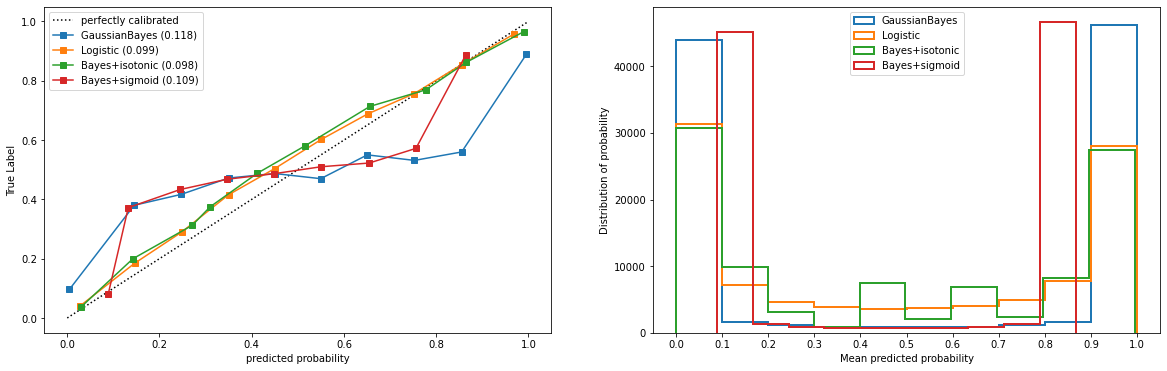

In [134]:
plot_calib(models,name,Xtrain,Xtest,Ytrain,Ytest)

In [135]:
# 准确率的变化

gnb = GaussianNB().fit(Xtrain,Ytrain)
gnb.score(Xtest,Ytest)

0.8650606060606061

In [136]:
brier_score_loss(Ytest,gnb.predict_proba(Xtest)[:,1],pos_label = 1)

0.11760826355000835

In [138]:
gnbisotonic = CalibratedClassifierCV(gnb, cv=2, method='isotonic').fit(Xtrain,Ytrain)
gnbisotonic.score(Xtest,Ytest)

0.8626767676767677

In [139]:
brier_score_loss(Ytest,gnbisotonic.predict_proba(Xtest)[:,1],pos_label = 1)

0.09833190251353853

SVC(gamma=1, kernel='linear') SVC
LogisticRegression(max_iter=3000) Logistic
CalibratedClassifierCV(base_estimator=SVC(gamma=1, kernel='linear'), cv=2,
                       method='isotonic') SVC+isotonic
CalibratedClassifierCV(base_estimator=SVC(gamma=1, kernel='linear'), cv=2) SVC+sigmoid


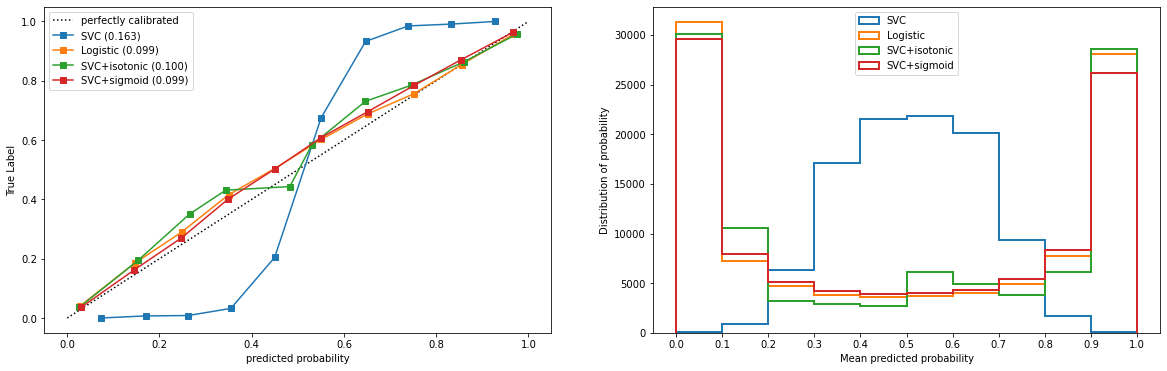

In [140]:
name_svc = ["SVC","Logistic","SVC+isotonic","SVC+sigmoid"]
svc = SVC(kernel = "linear",gamma=1)

models_svc = [svc
              ,LR(C=1., solver='lbfgs',max_iter=3000,multi_class="auto")
              #依然定义两种校准方式
              ,CalibratedClassifierCV(svc, cv=2, method='isotonic')
              ,CalibratedClassifierCV(svc, cv=2, method='sigmoid')
             ]

plot_calib(models_svc,name_svc,Xtrain,Xtest,Ytrain,Ytest)

In [141]:
name_svc = ["SVC","SVC+isotonic","SVC+sigmoid"]
svc = SVC(kernel = "linear",gamma=1)

models_svc = [svc
              ,CalibratedClassifierCV(svc, cv=2, method='isotonic')
              ,CalibratedClassifierCV(svc, cv=2, method='sigmoid')
             ]

for clf, name in zip(models_svc,name_svc):
    clf.fit(Xtrain,Ytrain)
    y_pred = clf.predict(Xtest)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(Xtest)[:, 1]
    else:
        prob_pos = clf.decision_function(Xtest)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    clf_score = brier_score_loss(Ytest, prob_pos, pos_label=y.max())
    score = clf.score(Xtest,Ytest)
    print("{}:".format(name))
    print("\tBrier:{:.4f}".format(clf_score))
    print("\tAccuracy:{:.4f}".format(score))

SVC:
	Brier:0.1630
	Accuracy:0.8633
SVC+isotonic:
	Brier:0.0999
	Accuracy:0.8639
SVC+sigmoid:
	Brier:0.0987
	Accuracy:0.8634


In [143]:
# 多项式朴素贝叶斯

from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs

In [144]:
class_1 = 500
class_2 = 500

centers = [[0.0, 0.0], [2.0, 2.0]]
clusters_std = [0.5, 0.5]
X, y = make_blobs(n_samples=[class_1, class_2]
                  ,centers=centers
                  ,cluster_std=clusters_std
                  ,random_state=0
                  ,shuffle=False
                 )

In [145]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.3, random_state=420)

In [146]:
# 归一化，求抱输入矩阵不带负数

nms = MinMaxScaler().fit(Xtrain)
Xtrain_ = nms.transform(Xtrain)
Xtest_ = nms.transform(Xtest)

In [148]:
mnb = MultinomialNB().fit(Xtrain_, Ytrain)

In [150]:
# 从数据获取的标签类的对数先验概率 log(P(Y))
mnb.class_log_prior_

array([-0.69029411, -0.69600841])

In [151]:
np.unique(Ytrain)

array([0, 1])

In [152]:
(Ytrain == 1).sum() / Ytrain.shape[0]

0.49857142857142855

In [153]:
mnb.class_log_prior_.shape

(2,)

In [154]:
np.exp(mnb.class_log_prior_)

array([0.50142857, 0.49857143])

In [155]:
# 返回固定标签类别下每个特征的对数概率 log(P(Xi|y))
mnb.feature_log_prob_

array([[-0.76164788, -0.62903951],
       [-0.72500918, -0.6622691 ]])

In [156]:
mnb.feature_log_prob_.shape

(2, 2)

In [157]:
# 在fit时每个标签类别下包含的样本数。当fit接口中的sample_weight被设置时,该接口返回的值也会受到加权的影响

mnb.class_count_

array([351., 349.])

In [158]:
mnb.class_count_.shape

(2,)

In [160]:
mnb.predict(Xtest_)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [161]:
mnb.predict_proba(Xtest_)

array([[0.49847128, 0.50152872],
       [0.50065987, 0.49934013],
       [0.50122363, 0.49877637],
       [0.50183745, 0.49816255],
       [0.50146433, 0.49853567],
       [0.50153147, 0.49846853],
       [0.50204549, 0.49795451],
       [0.50033124, 0.49966876],
       [0.50105254, 0.49894746],
       [0.50182815, 0.49817185],
       [0.50270707, 0.49729293],
       [0.50133396, 0.49866604],
       [0.49820896, 0.50179104],
       [0.50342829, 0.49657171],
       [0.50099022, 0.49900978],
       [0.49974388, 0.50025612],
       [0.50423879, 0.49576121],
       [0.50449207, 0.49550793],
       [0.49818224, 0.50181776],
       [0.50245485, 0.49754515],
       [0.50393627, 0.49606373],
       [0.50193571, 0.49806429],
       [0.49996152, 0.50003848],
       [0.50460038, 0.49539962],
       [0.50261175, 0.49738825],
       [0.50140163, 0.49859837],
       [0.50332522, 0.49667478],
       [0.50122253, 0.49877747],
       [0.50409939, 0.49590061],
       [0.49998717, 0.50001283],
       [0.

In [162]:
mnb.score(Xtest_, Ytest)

0.5433333333333333

In [163]:
brier_score_loss(Ytest, mnb.predict_proba(Xtest_)[:, 1], pos_label=1)

0.24977828412546027

In [193]:
# 将 Xtrain 分箱转换为分类型数据

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import recall_score, roc_auc_score

In [166]:
kbs = KBinsDiscretizer(n_bins=10, encode="onehot").fit(Xtrain)

In [167]:
Xtrain_ = kbs.transform(Xtrain)
Xtest_ = kbs.transform(Xtest)

In [168]:
mnb = MultinomialNB().fit(Xtrain_, Ytrain)

In [169]:
mnb.score(Xtest_, Ytest)

0.9966666666666667

In [170]:
brier_score_loss(Ytest, mnb.predict_proba(Xtest_)[:, 1], pos_label=1)

0.0014593932778211862

In [171]:
from sklearn.naive_bayes import BernoulliNB

In [173]:
#普通来说我们应该使用二值化的类sklearn.preprocessing.Binarizer来将特征一个个二值化
#然而这样效率过低,因此我们选择归一化之后直接设置一个阈值

nms = MinMaxScaler().fit(Xtrain)
Xtrain_ = nms.transform(Xtrain)
Xtest_ = nms.transform(Xtest)

In [174]:
# 不设置二值化

bn1_ = BernoulliNB().fit(Xtrain_, Ytrain)

In [175]:
bn1_.score(Xtest_, Ytest)

0.49666666666666665

In [176]:
brier_score_loss(Ytest, bn1_.predict_proba(Xtest_)[:, 1], pos_label=1)

0.25000009482193225

In [177]:
# 设置二值化阈值 0.5

bn1 = BernoulliNB(binarize=0.5).fit(Xtrain_, Ytrain)
bn1.score(Xtest_, Ytest)

0.9833333333333333

In [178]:
brier_score_loss(Ytest, bn1.predict_proba(Xtest_)[:, 1], pos_label=1)

0.010405875827339534

In [184]:
class_1 = 50000
class_2 = 500
centers = [[0.0, 0.0], [5.0, 5.0]]
clusters_std = [3, 1]
X, y = make_blobs(n_samples=[class_1, class_2]
                  ,centers=centers
                  ,cluster_std=clusters_std
                  ,random_state=420
                  ,shuffle=False
                 )

In [185]:
np.unique(y)

array([0, 1])

In [199]:
name = ["Multinomial", "Gaussian", "Bernoulli"]
models = [MultinomialNB(), GaussianNB(), BernoulliNB()]

for name_, clf in zip(name, models):
    # random_state 固定，则每次生成的集合都是一样的
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.3, random_state=420)
    
    if name_ != "Gaussian":
        kbs = KBinsDiscretizer(n_bins=10, encode="onehot").fit(Xtrain)
        Xtrain = kbs.transform(Xtrain)
        Xtest = kbs.transform(Xtest)
    
    clf.fit(Xtrain, Ytrain)
    y_pred = clf.predict(Xtest)
    proba = clf.predict_proba(Xtest)[:, 1]
    score = clf.score(Xtest, Ytest)
    print(name_)
    print("\tBrier:{:.3f}".format(brier_score_loss(Ytest,proba,pos_label=1)))
    print("\tAccuracy:{:.3f}".format(score))
    print("\tRecall:{:.3f}".format(recall_score(Ytest,y_pred)))
    print("\tAUC:{:.3f}".format(roc_auc_score(Ytest,proba)))

Multinomial
	Brier:0.006
	Accuracy:0.990
	Recall:0.000
	AUC:0.991
Gaussian
	Brier:0.006
	Accuracy:0.992
	Recall:0.458
	AUC:0.994
Bernoulli
	Brier:0.008
	Accuracy:0.989
	Recall:0.739
	AUC:0.991


In [200]:
# 补集朴素贝叶斯

from sklearn.naive_bayes import ComplementNB
from time import time
import datetime

In [201]:
name = ["Multinomial", "Gaussian", "Bernoulli", "Complement"]
models = [MultinomialNB(), GaussianNB(), BernoulliNB(), ComplementNB()]

for name_, clf in zip(name, models):
    times = time()
    # random_state 固定，则每次生成的集合都是一样的
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.3, random_state=420)
    
    if name_ != "Gaussian":
        kbs = KBinsDiscretizer(n_bins=10, encode="onehot").fit(Xtrain)
        Xtrain = kbs.transform(Xtrain)
        Xtest = kbs.transform(Xtest)
    
    clf.fit(Xtrain, Ytrain)
    y_pred = clf.predict(Xtest)
    proba = clf.predict_proba(Xtest)[:, 1]
    score = clf.score(Xtest, Ytest)
    print(name_)
    print("\tBrier:{:.3f}".format(brier_score_loss(Ytest,proba,pos_label=1)))
    print("\tAccuracy:{:.3f}".format(score))
    print("\tRecall:{:.3f}".format(recall_score(Ytest,y_pred)))
    print("\tAUC:{:.3f}".format(roc_auc_score(Ytest,proba)))
    print(datetime.datetime.fromtimestamp(time() - times).strftime("%M:%S:%f"))

Multinomial
	Brier:0.006
	Accuracy:0.990
	Recall:0.000
	AUC:0.991
00:00:027006
Gaussian
	Brier:0.006
	Accuracy:0.992
	Recall:0.458
	AUC:0.994
00:00:016107
Bernoulli
	Brier:0.008
	Accuracy:0.989
	Recall:0.739
	AUC:0.991
00:00:026895
Complement
	Brier:0.040
	Accuracy:0.953
	Recall:0.993
	AUC:0.991
00:00:025469
